In [1]:
import pandas as pd
import numpy as np
import math
from random import choices
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import statistics

In [2]:
import devanalyst.simulation.statics as S_
import devanalyst.simulation.GenerateTimecards as timecard
from devanalyst.simulation.GenerateTimecards import WorkAssignments
from devanalyst.simulation.simulationModels import BalancedAllocationModel, GreedyAllocationModel, ModelsConfig, DefaultCostModel

importing Jupyter notebook from c:\alex\code\labs\devanalyst\devanalyst\simulation\statics.ipynb
importing Jupyter notebook from c:\alex\code\labs\devanalyst\devanalyst\simulation\GenerateTimecards.ipynb
importing Jupyter notebook from c:\alex\code\labs\devanalyst\devanalyst\simulation\simulationModels.ipynb


In [3]:
import devanalyst.simulation.tests.test_utils as tu_

importing Jupyter notebook from c:\alex\code\labs\devanalyst\devanalyst\simulation\tests\test_utils.ipynb


<h1>test_balancedAllocation</h1>

In [ ]:
# Implement test logic, and run it

#Test logic
def test_balancedAllocation():    
    output = {}
    RELEASE_DURATION = 125
    SPRINT_DURATION = 10

    # Configure models
    model = BalancedAllocationModel(SPRINT_DURATION) 
    modelsConfig = ModelsConfig([], [], model)
    modelsConfig.random.reset(271)

    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, tu_.PM_DF, \
                                                                             RELEASE_DURATION, SPRINT_DURATION, modelsConfig)

    # Select a team
    teamId = teams_df['Scrum Team'][0].teamId
    
    # Choose what to work on at the start of a sprint.
    SPRINT_DURATION = 10

   
    work = WorkAssignments(teamId, teamsRepo, storiesRepo, sprint=1)

    work = model.allocate(work, modelsConfig)
    
    committed_df = work.committedTime(SPRINT_DURATION)
    tasks_df = work.committedTasks()
        
    output['Committed'] = committed_df
    output['Tasks'] = tasks_df
    return output, work

# Run the test
test_balancedAllocation_ACTUAL, work = test_balancedAllocation()

In [ ]:
#test_balancedAllocation_ACTUAL['Committed']

In [ ]:
#test_balancedAllocation_ACTUAL['Tasks']

<h1>Pilots</h1>

In [4]:
def getPlans(work):
    unassigned = work.allocations[S_.UNPLANNED][S_.OWNER_TBD]
    unplanned = []
    unplanned.extend(unassigned[S_.BUGS_ON_COMPLETED_STORIES])
    unplanned.extend(unassigned[S_.BUGS_ON_UNFINISHED_STORIES])
    unplanned.extend(unassigned[S_.UNFINISHED_STORIES])
    
    planned_CURRENT_SPRINT = []
    subwork = work.allocations[S_.CURRENT_SPRINT]
    for person in subwork.keys():
        planned_CURRENT_SPRINT.extend(subwork[person][S_.BUGS_ON_COMPLETED_STORIES])
        planned_CURRENT_SPRINT.extend(subwork[person][S_.BUGS_ON_UNFINISHED_STORIES])
        planned_CURRENT_SPRINT.extend(subwork[person][S_.UNFINISHED_STORIES])

    planned_NEXT_SPRINT = []
    subwork = work.allocations[S_.NEXT_SPRINT]
    for person in subwork.keys():
        planned_NEXT_SPRINT.extend(subwork[person][S_.BUGS_ON_COMPLETED_STORIES])
        planned_NEXT_SPRINT.extend(subwork[person][S_.BUGS_ON_UNFINISHED_STORIES])
        planned_NEXT_SPRINT.extend(subwork[person][S_.UNFINISHED_STORIES])

            
    return planned_CURRENT_SPRINT, planned_NEXT_SPRINT, unplanned

In [5]:
def captureReleasePlans():    
# Run a release cycle and capture all the plans at the start and end of each sprint
    output = {}

    SPRINT_DURATION = 10
    NUMBER_OF_SPRINTS = 15
    EXTRA_SPRINTS_BUFFER = 5 # Buffer to finish up work that didn't fit into the intended number of sprints
    RELEASE_DURATION = SPRINT_DURATION * NUMBER_OF_SPRINTS

    # Configure models
    model = BalancedAllocationModel(SPRINT_DURATION) 
    modelsConfig = ModelsConfig([], [], model)
    modelsConfig.random.reset(271)

    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, tu_.PM_DF, \
                                                                             RELEASE_DURATION, SPRINT_DURATION, modelsConfig)
    # Select a team
    teamId = teams_df['Scrum Team'][0].teamId

    # Go through the sprints
    for n in range(NUMBER_OF_SPRINTS + EXTRA_SPRINTS_BUFFER):
        sprint = n+1
        output[sprint] = {}
        
        work = WorkAssignments(teamId, teamsRepo, storiesRepo, sprint) 
        
        #Debugging
        if (sprint==1):
            committed_df = work.committedTime(SPRINT_DURATION)
            tasks_df = work.committedTasks()

        planned_start_CURRENT_SPRINT, planned_start_NEXT_SPRINT, unplanned_start = getPlans(work)
        output[sprint]['planned_start_CURRENT_SPRINT'] = planned_start_CURRENT_SPRINT
        output[sprint]['planned_start_NEXT_SPRINT'] = planned_start_NEXT_SPRINT
        output[sprint]['unplanned_start'] = unplanned_start

        work = timecard.chooseWhatToDoInSprint(teamId, teamsRepo, storiesRepo, SPRINT_DURATION, modelsConfig, sprint)           
        timecard.deliverSprint(teamId, teamsRepo, ticketsRepo, storiesRepo, work, SPRINT_DURATION, modelsConfig) # mutates 'work'
        inflow = timecard.inflowOfTickets(teamId, teamsRepo, ticketsRepo, storiesRepo)
        timecard.updateBacklogAfterSprint(teamId, teamsRepo, ticketsRepo, storiesRepo, work, inflow) # Does not mutate 'work'
    
        planned_end_CURRENT_SPRINT, planned_end_NEXT_SPRINT, unplanned_end = getPlans(work)
        output[sprint]['planned_end_CURRENT_SPRINT'] = planned_end_CURRENT_SPRINT
        output[sprint]['planned_end_NEXT_SPRINT'] = planned_end_NEXT_SPRINT
        output[sprint]['unplanned_end'] = unplanned_end
    
    return output, committed_df, tasks_df, teamsRepo, storiesRepo, modelsConfig
plans, c1, t1, TEAMS_REPO, STORIES_REPO, MODELS_CONFIG = captureReleasePlans()

In [6]:
def _buildDistribution(snapshot, model):
    distribution = {}
    for e in snapshot:
        x = model._getBin(e)                       
        if x in distribution:
            distribution[x] = distribution[x] + 1
        else:
            distribution[x] = 1                
    return distribution    

def _calcSnapshotDistance(snapshot1, snapshot2, model):
    return model._measureDistributionDistance(_buildDistribution(snapshot1, model), \
                                             _buildDistribution(snapshot2, model))

In [7]:
def _plotPlansHelper(sprint, releasePlans, sprintDuration, figure, snapshot, ax, color):

    #ax = figure.add_subplot(2,3,ax_idx)
    
    data = []
    target = []
    if sprint -1 < len(releasePlans): # sprints start at 1, 2, 3, ... wheras len(releasePlans) goes 0, 1, 2, ..., 
        for item in releasePlans[sprint][snapshot]:
            data.append(item.estimate)
        for item in releasePlans[sprint]['unplanned_start']:
            target.append(item.estimate)
            
    sns.distplot(data, bins=sprintDuration, color=color, ax=ax)
    #ax1.legend(loc ='best')
    ax.set_title(snapshot)
    if len(data)==0:
        mean = 0
    else:
        mean = statistics.mean(data)
        
    model = BalancedAllocationModel(sprintDuration)

    
    distance = _calcSnapshotDistance(data, target, model)
    
    ax.set_xlabel('size=' + str(len(data)) + '; mean=' + str(round(mean, 2)) + '; distance=' + str(round(distance,2)))
    
def plotPlans(sprint, releasePlans, sprintDuration):
    #fig = plt.figure()

    fig, axs = plt.subplots(2, 3)   

    fig.suptitle('--------------------------------------------- SPRINT '+ str(sprint) + 
                 ' ---------------------------------------------', fontsize=16, y=1.4, x=1)

    _plotPlansHelper(sprint, releasePlans, sprintDuration, fig, 'unplanned_start', axs[0][0], 'g')
    _plotPlansHelper(sprint, releasePlans, sprintDuration, fig, 'planned_start_CURRENT_SPRINT', axs[0][1], 'b')
    _plotPlansHelper(sprint, releasePlans, sprintDuration, fig, 'planned_start_NEXT_SPRINT', axs[0][2], 'b')
    _plotPlansHelper(sprint, releasePlans, sprintDuration, fig, 'unplanned_end', axs[1][0], 'g')
    _plotPlansHelper(sprint, releasePlans, sprintDuration, fig, 'planned_end_CURRENT_SPRINT', axs[1][1], 'b')
    _plotPlansHelper(sprint, releasePlans, sprintDuration, fig, 'planned_end_NEXT_SPRINT', axs[1][2], 'b')
    
    plt.subplots_adjust(top=1.2, right=2.3, wspace=0.3, hspace=0.5)

C:\Alex\CodeImages\technos\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Alex\CodeImages\technos\anaconda3\lib\site-packages\numpy\lib\histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


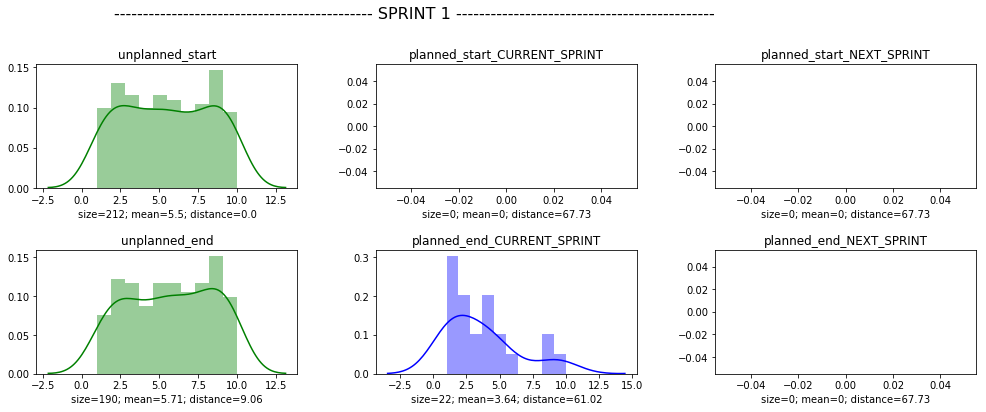

In [8]:
plotPlans(1, plans, 10)

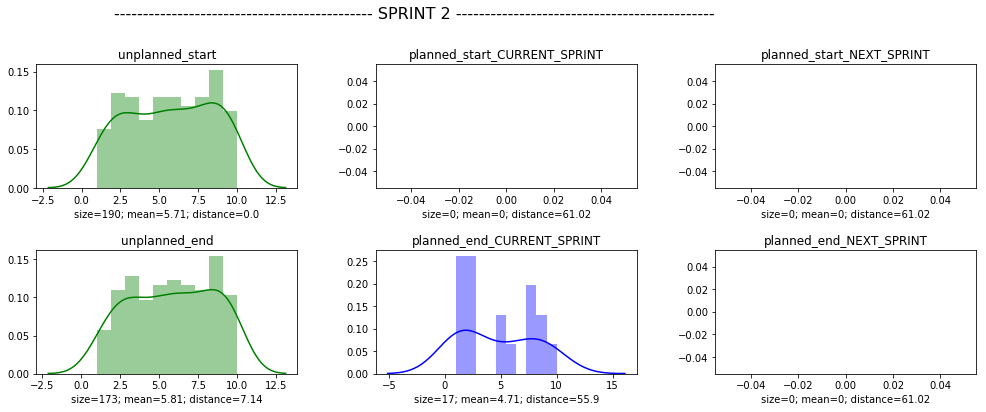

In [9]:
plotPlans(2, plans, 10)

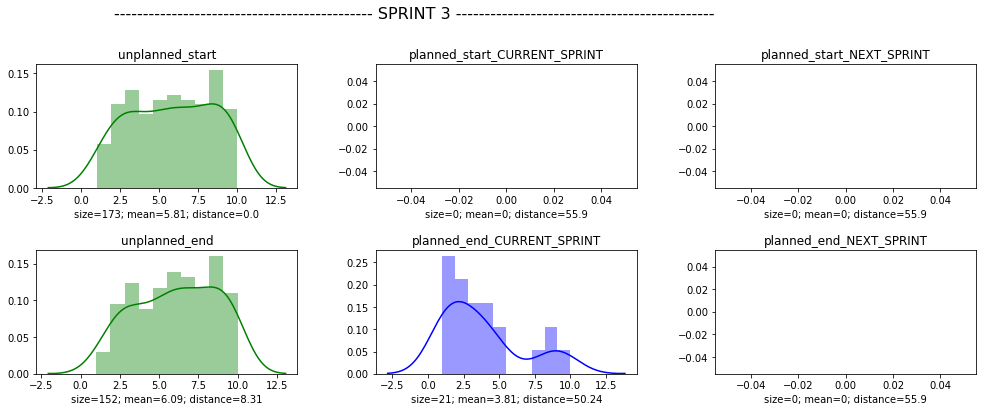

In [10]:
plotPlans(3, plans, 10)

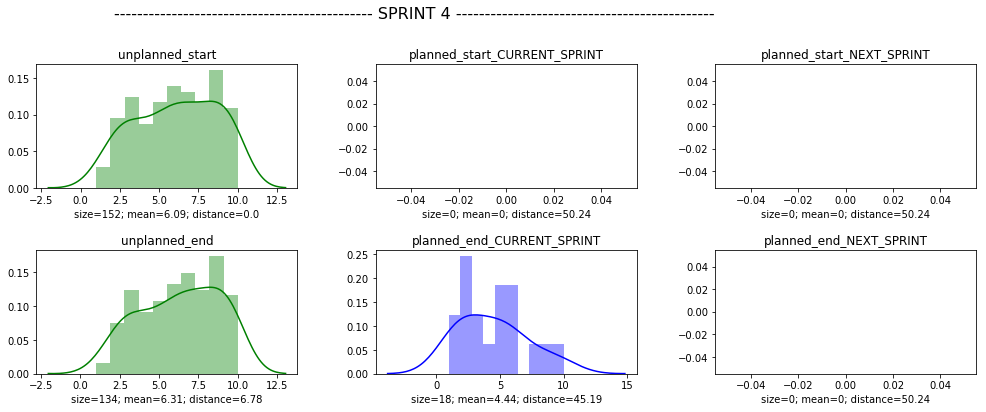

In [11]:
plotPlans(4, plans, 10)

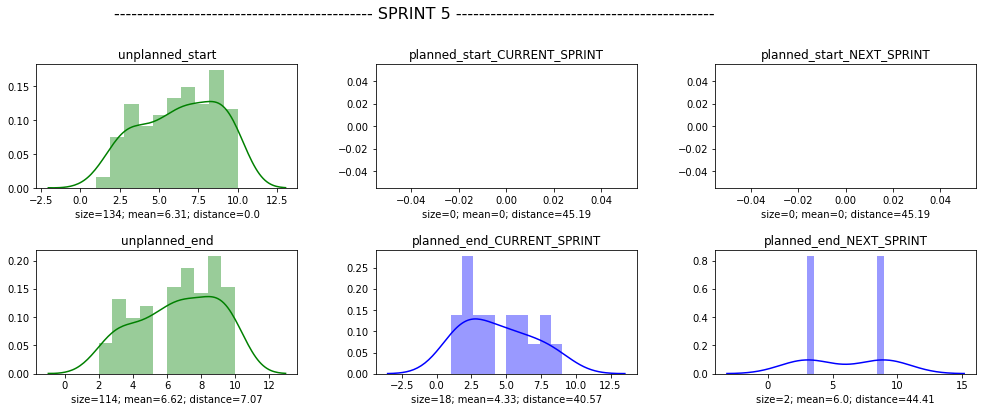

In [12]:
plotPlans(5, plans, 10)

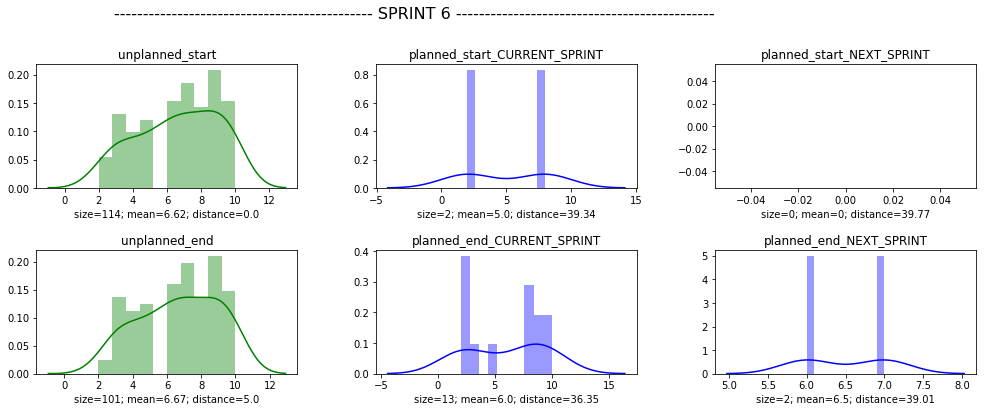

In [13]:
plotPlans(6, plans, 10)

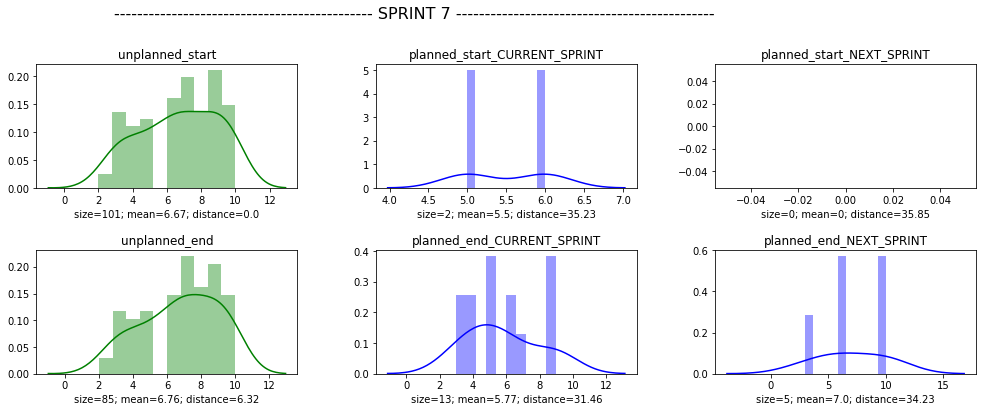

In [14]:
plotPlans(7, plans, 10)

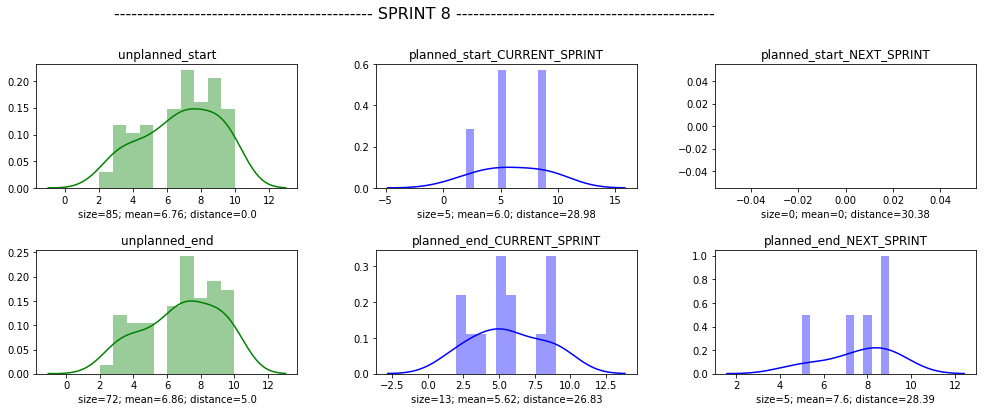

In [15]:
plotPlans(8, plans, 10)

C:\Alex\CodeImages\technos\anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Alex\CodeImages\technos\anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Alex\CodeImages\technos\anaconda3\lib\site-packages\statsmodels\nonparametric\bandwidths.py:20: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)
C:\Alex\CodeImages\technos\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


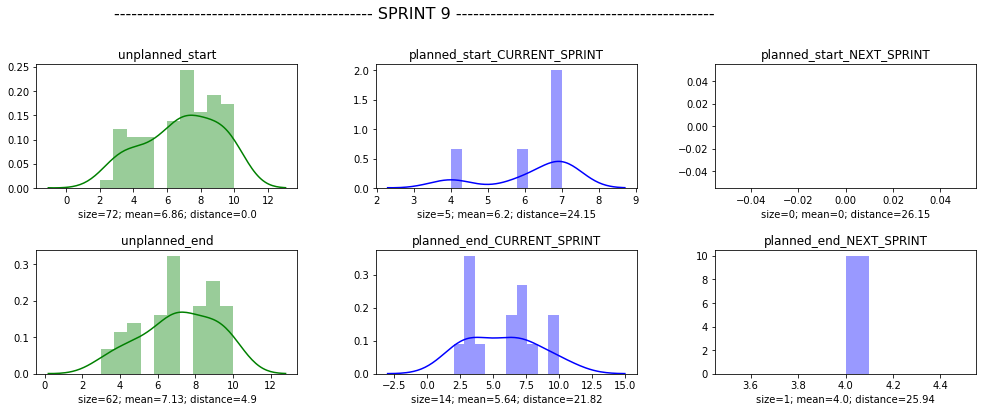

In [16]:
plotPlans(9, plans, 10)

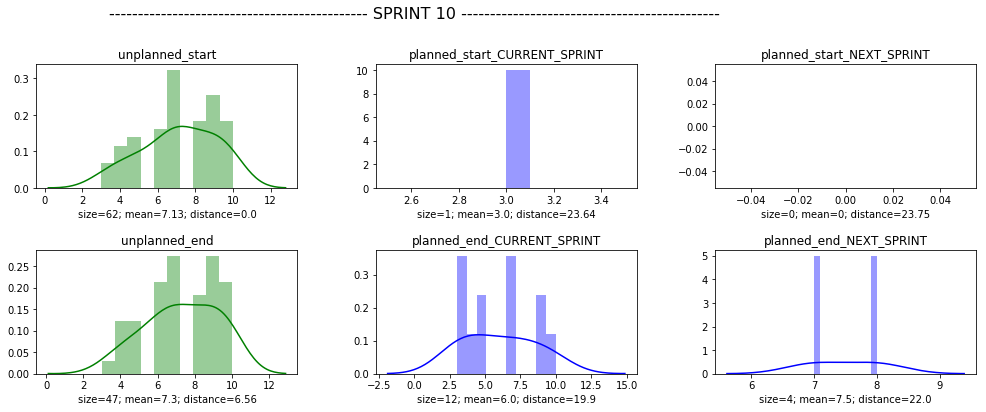

In [17]:
plotPlans(10, plans, 10)

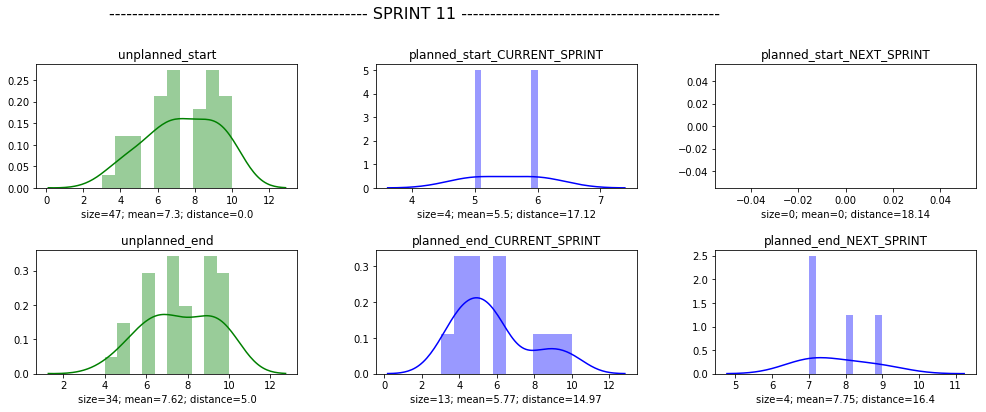

In [18]:
plotPlans(11, plans, 10)

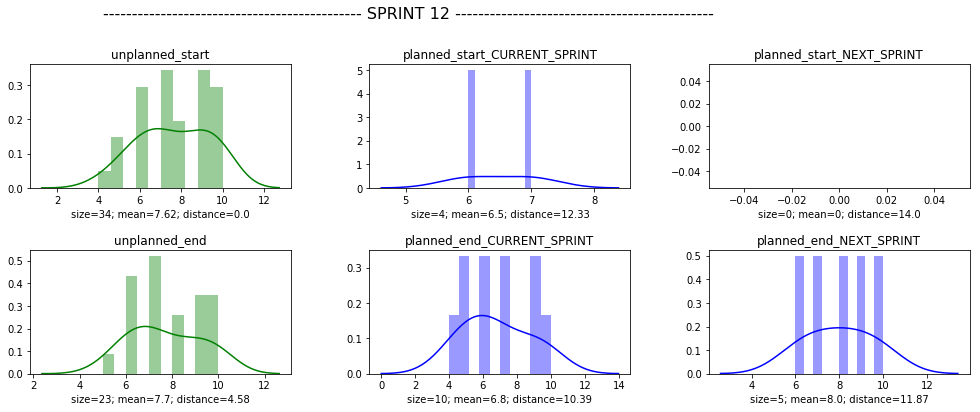

In [19]:
plotPlans(12, plans, 10)

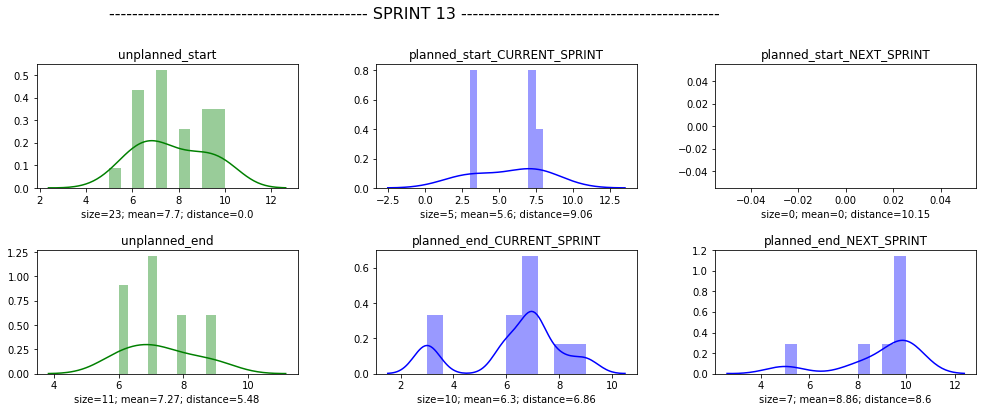

In [20]:
plotPlans(13, plans, 10)

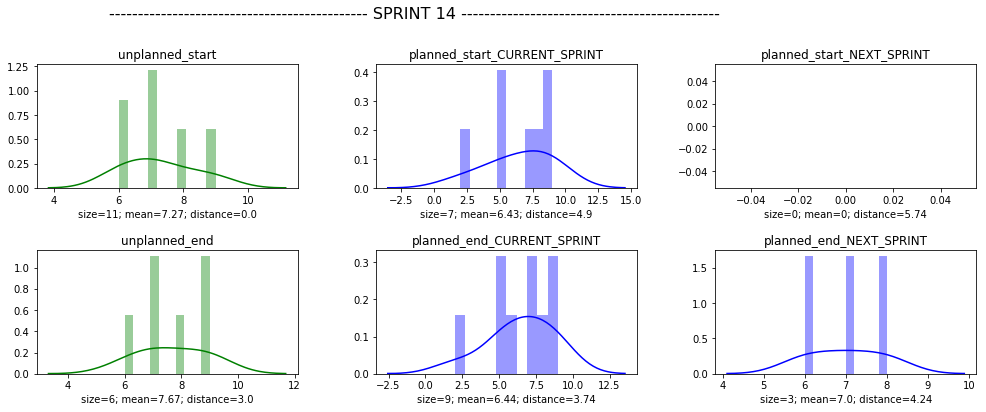

In [21]:
plotPlans(14, plans, 10)

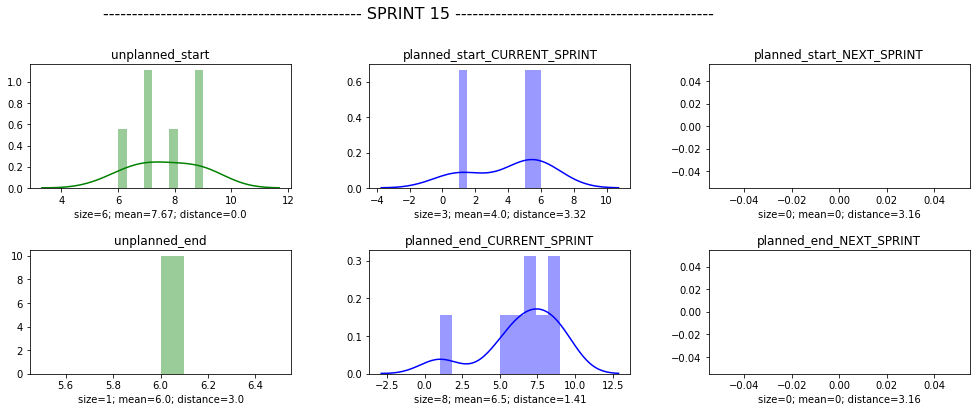

In [22]:
plotPlans(15, plans, 10)

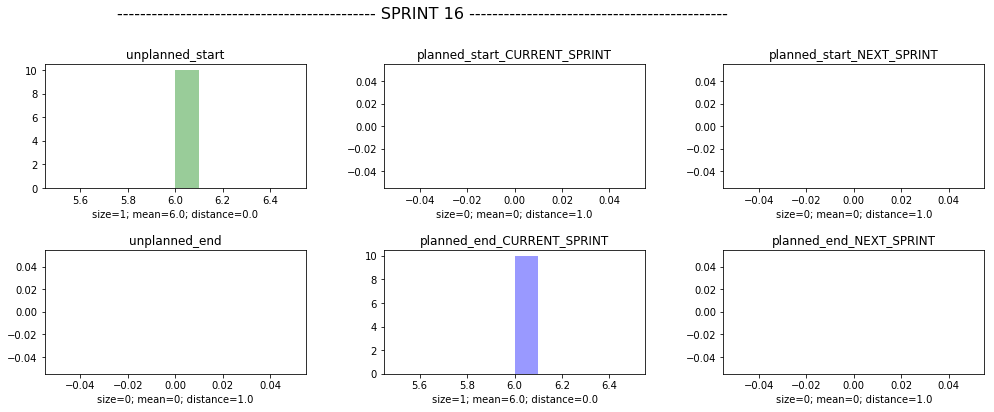

In [23]:
plotPlans(16, plans, 10)

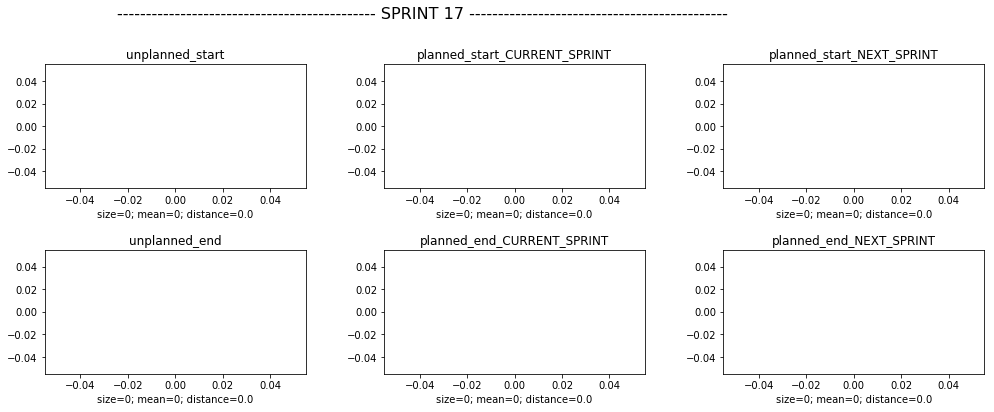

In [24]:
plotPlans(17, plans, 10)

<h1>Scrap</h1>

In [25]:
# 
def genReleaseCycle(modelsConfig):
    RELEASE_DURATION = 125
    SPRINT_DURATION = 10
    
    tu_.loadTestResources()
    
    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, \
                                                                                           tu_.PM_DF, \
                                                                                           RELEASE_DURATION, \
                                                                                           SPRINT_DURATION, \
                                                                                          modelsConfig)
    
    NUMBER_OF_SPRINTS = 25

    entries_df, worksheets = timecard.runReleaseCycle(teamsRepo, ticketsRepo, storiesRepo, datetime(2018, 1, 15), \
                                                   SPRINT_DURATION, NUMBER_OF_SPRINTS, modelsConfig)    
    
    return entries_df, worksheets

In [26]:
def genBurnout(entries_df):
    bystory = entries_df.groupby('User Story')
    u = bystory.apply(storyInfo)
    u = u.reset_index()
    u.drop(['level_1'], axis='columns', inplace=True)
    s = u.groupby('Final Sprint')
    burnout = s.apply(sprintInfo)
    burnout = burnout.reset_index()
    burnout.drop(['level_1'], axis='columns', inplace=True)
    return burnout, u

In [27]:
def storyInfo(group_df):
    info = {}
    
    #Go back, as min['Date'] is end of first sprint
    info['Start'] = [timecard.subtractBusinessDays(group_df['Date'].min(), SPRINT_DURATION)] 
    info['End'] = [group_df['Date'].max()]
    info['Elapsed Time'] = (info['End'][0] - info['Start'][0]).days
    info['Effort'] = group_df['Time Spent'].sum()
    info['Initial Sprint'] = [group_df['Sprint'].min()]
    info['Final Sprint'] = [group_df['Sprint'].max()]  
    
    return pd.DataFrame(info)

In [28]:
def sprintInfo(group_df):
    info = {}
    
    info['Effort'] = group_df['Effort'].sum()
    info['Avg Effort'] = group_df['Effort'].mean()
    info['Stories Completed'] = [group_df['User Story'].count()]
    info['Over 1 sprint'] = [group_df[group_df['Elapsed Time']==14]['User Story'].count()]
    info['Over 2 sprint'] = [group_df[group_df['Elapsed Time']==28]['User Story'].count()]
    info['Over 3 sprint'] = [group_df[group_df['Elapsed Time']==42]['User Story'].count()]
    info['Over 4 sprint'] = [group_df[group_df['Elapsed Time']==56]['User Story'].count()]
 
    
    return pd.DataFrame(info)

In [29]:
SPRINT_DURATION = 10
modelsConfig1 = ModelsConfig([DefaultCostModel(0.0)], [], BalancedAllocationModel(SPRINT_DURATION)) 
modelsConfig1.random.reset(271)
entries_df1, worksheets1 = genReleaseCycle(modelsConfig1)

In [30]:
burn1, u1 = genBurnout(entries_df1)
burn1

,Final Sprint,Effort,Avg Effort,Stories Completed,Over 1 sprint,Over 2 sprint,Over 3 sprint,Over 4 sprint
0,1,300.0,3.846154,78,78,0,0,0
1,2,300.0,4.166667,72,72,0,0,0
2,3,300.0,4.166667,72,72,0,0,0
3,4,293.0,4.803279,61,61,0,0,0
4,5,297.0,5.500000,54,47,7,0,0
5,6,300.0,5.454545,55,45,10,0,0
6,7,291.0,6.062500,48,39,9,0,0
7,8,297.0,6.456522,46,29,17,0,0
8,9,283.0,7.256410,39,25,14,0,0
9,10,289.0,6.880952,42,23,19,0,0


In [31]:
u1

,User Story,Start,End,Elapsed Time,Effort,Initial Sprint,Final Sprint
0,UserStory #1,2018-06-04,2018-07-02,28,10.0,11,12
1,UserStory #10,2018-06-04,2018-07-02,28,9.0,11,12
2,UserStory #100,2018-05-21,2018-06-18,28,8.0,10,11
3,UserStory #101,2018-04-09,2018-05-07,28,9.0,7,8
4,UserStory #102,2018-04-09,2018-04-23,14,6.0,7,7
5,UserStory #103,2018-01-15,2018-01-29,14,7.0,1,1
6,UserStory #104,2018-02-12,2018-02-26,14,5.0,3,3
7,UserStory #105,2018-01-29,2018-02-12,14,4.0,2,2
8,UserStory #106,2018-05-21,2018-06-04,14,7.0,10,10
9,UserStory #107,2018-02-26,2018-03-12,14,3.0,4,4


In [32]:
SPRINT_DURATION = 10
modelsConfig2 = ModelsConfig([DefaultCostModel(0.0)], [], GreedyAllocationModel(SPRINT_DURATION)) 
modelsConfig2.random.reset(271)
entries_df2, worksheets2 = genReleaseCycle(modelsConfig2)

In [33]:
burn2, u2 = genBurnout(entries_df2)
burn2

,Final Sprint,Effort,Avg Effort,Stories Completed,Over 1 sprint,Over 2 sprint,Over 3 sprint,Over 4 sprint
0,1,300.0,4.054054,74,74,0,0,0
1,2,300.0,3.947368,76,76,0,0,0
2,3,298.0,4.257143,70,70,0,0,0
3,4,298.0,4.656250,64,62,2,0,0
4,5,289.0,4.982759,58,54,4,0,0
5,6,301.0,6.270833,48,35,13,0,0
6,7,285.0,5.937500,48,36,12,0,0
7,8,298.0,6.208333,48,31,17,0,0
8,9,300.0,6.382979,47,27,20,0,0
9,10,281.0,7.205128,39,22,17,0,0


(<matplotlib.axes._subplots.AxesSubplot at 0x1fd88319ac8>,
 <matplotlib.legend.Legend at 0x1fd8824cf28>)

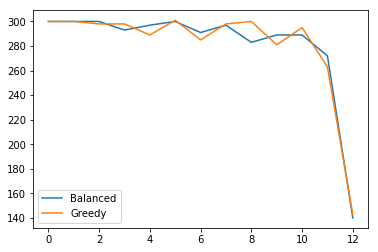

In [34]:
burn1['Effort'].plot(label = 'Balanced'), burn2['Effort'].plot(label = 'Greedy'), plt.legend()

(<matplotlib.axes._subplots.AxesSubplot at 0x1fd87eff828>,
 <matplotlib.legend.Legend at 0x1fd87eff518>)

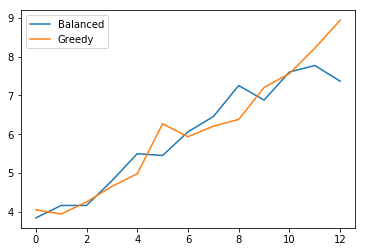

In [35]:
burn1['Avg Effort'].plot(label = 'Balanced'), burn2['Avg Effort'].plot(label = 'Greedy'), plt.legend()